In [ ]:
!pip install stop_words

  Created wheel for stop-words: filename=stop_words-2018.7.23-py3-none-any.whl size=32911 sha256=942dac333de687107abfb68f25dfcd18bf441806ed5d5b43c13bc29d86107bb6
  Stored in directory: /root/.cache/pip/wheels/fb/86/b2/277b10b1ce9f73ce15059bf6975d4547cc4ec3feeb651978e9
Successfully built stop-words


In [ ]:
!pip install pymorphy2

     |████████████████████████████████| 55 kB 2.1 MB/s 
     |████████████████████████████████| 8.2 MB 8.4 MB/s 


In [ ]:
max_words = 300 #2000
max_len = 20 #40
num_classes = 1

# Training
epochs = 20
batch_size = 512
print_batch_n = 100

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

df_train = pd.read_csv("/content/drive/MyDrive/PyTorch/7/data/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/PyTorch/7/data/test.csv")
df_val = pd.read_csv("/content/drive/MyDrive/PyTorch/7/data/val.csv")

In [ ]:
df_train.head()

,id,text,class
0,0,@alisachachka не уезжаааааааай. :(❤ я тоже не ...,0
1,1,RT @GalyginVadim: Ребята и девчата!\nВсе в кин...,1
2,2,RT @ARTEM_KLYUSHIN: Кто ненавидит пробки ретви...,0
3,3,RT @epupybobv: Хочется котлету по-киевски. Зап...,1
4,4,@KarineKurganova @Yess__Boss босапопа есбоса н...,1


In [ ]:
from string import punctuation
from stop_words import get_stop_words
from pymorphy2 import MorphAnalyzer
import re

In [ ]:
sw = set(get_stop_words("ru"))
exclude = set(punctuation)
morpher = MorphAnalyzer()

def preprocess_text(txt):
    txt = str(txt)
    txt = "".join(c for c in txt if c not in exclude)
    txt = txt.lower()
    txt = re.sub("\sне", "не", txt)
    txt = [morpher.parse(word)[0].normal_form for word in txt.split() if word not in sw]
    return " ".join(txt)

df_train['text'] = df_train['text'].apply(preprocess_text)
df_val['text'] = df_val['text'].apply(preprocess_text)
df_test['text'] = df_test['text'].apply(preprocess_text)

In [ ]:
train_corpus = " ".join(df_train["text"])
train_corpus = train_corpus.lower()

In [ ]:
import nltk
from nltk.tokenize import word_tokenize
nltk.download("punkt")

tokens = word_tokenize(train_corpus)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
tokens_filtered = [word for word in tokens if word.isalnum()]

In [ ]:
from nltk.probability import FreqDist
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [ ]:
tokens_filtered_top[10:]

['хороший',
 'делать',
 'день',
 'смотреть',
 'вообще',
 'думать',
 'идти',
 'иня',
 'блин',
 'самый',
 'спать',
 'сидеть',
 'дом',
 'пойти',
 '3',
 'писать',
 'друг',
 'один',
 'сделать',
 'утро',
 'школа',
 '2',
 'ждать',
 'человек',
 'час',
 'настроение',
 'такой',
 'мама',
 'любимый',
 'хотеться',
 'болеть',
 'написать',
 'говорить',
 'видеть',
 'работа',
 'свой',
 'посмотреть',
 'последний',
 'прийти',
 'добрый',
 'ночь',
 'понять',
 'купить',
 'какой',
 'найти',
 'понимать',
 'нравиться',
 'чтоть',
 'скоро',
 'скучать',
 'вчера',
 'давать',
 'читать',
 'стать',
 'дело',
 'остаться',
 'забыть',
 'работать',
 'первый',
 'плохо',
 'фильм',
 'урок',
 'оо',
 'жить',
 'голова',
 'ничегон',
 'вечер',
 'снег',
 'твой',
 'ходить',
 'домой',
 'пара',
 'дать',
 'сон',
 '5',
 'нужный',
 'нг',
 'телефон',
 'жизнь',
 'надеяться',
 'жаль',
 '4',
 'бля',
 'правда',
 'ахи',
 'сказать',
 'песня',
 'улица',
 'наш',
 'увидеть',
 'слово',
 'твиттер',
 'изз',
 'парень',
 'плохой',
 'вроде',
 'место',


In [ ]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [ ]:
import numpy as np
def text_to_sequence(text, maxlen):
    result = []
    tokens = word_tokenize(text.lower())
    tokens_filtered = [word for word in tokens if word.isalnum()]
    for word in tokens_filtered:
        if word in vocabulary:
            result.append(vocabulary[word])
    padding = [0]*(maxlen-len(result))
    return result[-maxlen:] + padding

In [ ]:
x_train = np.asarray([text_to_sequence(text, max_len) for text in df_train["text"]], dtype=np.int32)
x_test = np.asarray([text_to_sequence(text, max_len) for text in df_test["text"]], dtype=np.int32)
x_val = np.asarray([text_to_sequence(text, max_len) for text in df_val["text"]], dtype=np.int32)

In [ ]:
x_train.shape

(181467, 20)

In [ ]:
x_train[1]

array([  1, 213, 170,   9,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [ ]:
import random
import torch
import torch.nn as nn

seed = 0

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [ ]:
class Net(nn.Module):
    def __init__(self, vocab_size=20, embedding_dim = 128, out_channel = 128, num_classes = 1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)
        
    def forward(self, x):        
        output = self.embedding(x)
        #                       B  F  L         
        output = output.permute(0, 2, 1)
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        
        return output
    
    def predict(self, x):
        return F.softmax(self.forward(x))

In [ ]:
from torch.utils.data import DataLoader, Dataset

class DataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else None
        
        if self.transform:
            x = self.transform(x)
            
        return x, y
    
    def __len__(self):
        return len(self.data)

In [ ]:
model = Net(vocab_size=max_words)

print(model)
print("Parameters:", sum([param.nelement() for param in model.parameters()]))

model.train()
#model = model.cuda()

optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)
criterion = nn.BCEWithLogitsLoss()

    
train_dataset = DataWrapper(x_train, df_train['class'].values)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = DataWrapper(x_val, df_val['class'].values)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

loss_history = []

for epoch in range(1, epochs + 1):
    print(f"Train epoch {epoch}/{epochs}")
    for i, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # data = data.cuda()
        # target = target.cuda()
        
        # compute output
        output = model(data)
        
        # compute gradient and do SGD step
        loss = criterion(output, target.float().view(-1, 1))
        loss.backward()
        
        optimizer.step()
        
        if i%print_batch_n == 0:
            loss = loss.float().item()
            print("Step {}: loss={}".format(i, loss))
            loss_history.append(loss)

Net(
  (embedding): Embedding(300, 128)
  (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=1, bias=True)
)
Parameters: 87809
Train epoch 1/20
Step 0: loss=0.6932660937309265
Step 100: loss=0.6696129441261292
Step 200: loss=0.64694744348526
Step 300: loss=0.6134774684906006
Train epoch 2/20
Step 0: loss=0.6187741756439209
Step 100: loss=0.603071391582489
Step 200: loss=0.5826130509376526
Step 300: loss=0.5884585380554199
Train epoch 3/20
Step 0: loss=0.577396810054779
Step 100: loss=0.6047444939613342
Step 200: loss=0.6081106066703796
Step 300: loss=0.5713151693344116
Train epoch 4/20
Step 0: loss=0.5963743329048157
Step 100: loss=0.6055018901824951
Step 200: loss=0.5879409313201904
Step 300: loss=0.5843804478645325
Train epoch 5/20
Step 0: loss=0.5578847527503967
Step 100: loss=0.5645507574081421
Step 200: loss=0.6009809374809265
Step 300: loss=0.5956822633743286
Train epoch 6/20
Step 0: loss=0.5851104259490967
St

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random', 'seed']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


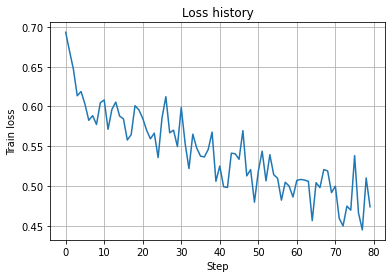

In [ ]:
import matplotlib.pyplot as plt
%pylab inline
plt.title('Loss history')
plt.grid(True)
plt.ylabel('Train loss')
plt.xlabel('Step')
plt.plot(loss_history);

In [ ]:
test_dataset = DataWrapper(x_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)